# Importation des packages

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, roc_auc_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.svm import LinearSVC
import shap
from xgboost.sklearn  import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

import ipywidgets as widgets
from ipywidgets import Layout


# Fonctions

In [2]:
def plot_NA(data: pd.DataFrame):
    """ Plot a histogram of empty values percentage per columns of the input DataFrame
    """
    columns_emptiness = pd.DataFrame({
        col : { 
            'count': data[col].isna().sum(),
            'percent': 100 * data[col].isna().sum() / data.shape[0],
        } for col in data.columns
    }).transpose()
    fig = px.bar(columns_emptiness,
        color='count',
        y='percent',
        hover_data=['count'],
        title='NA per column',
        width=1200,
        height=600)
    fig.show()
    
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()           
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df) 
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

    
def delete_NA(data: pd.DataFrame, perc=30):
    """[summary]
    Args:
        data (pd.DataFrame): [description]
        perc (int, optional): [description]. Defaults to 80.
    """
    #Supprime les lignes ou colonnes avec 80% de valeurs manquantes 
    min_count = int(((100-perc)/100)*data.shape[0] + 1)
    data = data.dropna(axis=1, thresh=min_count)
    data = data.dropna(axis=0, how = 'any')
    return(data)

def Impute(data):
    tgt = list(['TARGET'])
    dataSI = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(data.drop(["TARGET"], axis=1)), columns = data.drop(["TARGET"], axis=1).columns)
    data = pd.concat([data[tgt].reset_index(drop=True), dataSI.reset_index(drop = True)], axis=1)
    return(data)

def plot(n):
    sns.displot(application_train, x=n, hue="TARGET")
    plt.figure();


def IQR_filter(s: pd.DataFrame, col_num: list, replace=np.nan):
    """[summary]
    Args:
        s (pd.DataFrame): [description]
        col_num (list): [description]
        replace ([type], optional): [description]. Defaults to np.nan.
    """
    for col in col_num:
        Q1 = s[col].quantile(0.25)
        Q3 = s[col].quantile(0.75)
        IQR = Q3-Q1
        s.loc[:,col] = s[col].where((s[col] > (Q1 - 1.5 * IQR)) & (s[col] < (Q3 + 1.5 * IQR)))  
    return(s)


# Kernel Kaggle

In [3]:
#Kernel 
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns    

# Preprocess application_train.csv and application_test.csv
def application_train_test(train, num_rows = None, nan_as_category = False):
    # Read data and merge
    df = train
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Categorical features with Binary encode (0 or 1; two categories)
    for col in df:
        if df.loc[:,col].dtype == 'object':
        # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                df.loc[:,col] = LabelEncoder().fit_transform(df.loc[:,col])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(bureau, bureau_balance, nan_as_category = True):
    bureau = bureau
    bb = bureau_balance
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications_t(previous_application):
    prev = previous_applications
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(POS_CASH_balance, nan_as_category = True):
    pos = POS_CASH_balance
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments_t(installments_payments, nan_as_category = True):
    ins = installments_payments
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance_t(credit_card_balance, nan_as_category = True):
    cc = credit_card_balance
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    return cc_agg

# Lecture des fichiers

In [4]:
application_train = pd.read_csv("application_train.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
credit_card_balance = pd.read_csv("credit_card_balance.csv")
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")
previous_applications = pd.read_csv("previous_application.csv")
sample_submission = pd.read_csv("sample_submission.csv")
installments_payments = pd.read_csv("installments_payments.csv")

# Analyse exploratoire de application_train

## Dimenssion

In [5]:
print('Training data shape: ', application_train.shape)

Training data shape:  (307511, 122)


## Statistiques

In [6]:
application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [7]:
ori = application_train.columns

In [8]:
plot_columns=[
            "AMT_INCOME_TOTAL",
            "AMT_CREDIT",
            "AMT_ANNUITY",
            "AMT_GOODS_PRICE",
            "DAYS_BIRTH",
            "DAYS_EMPLOYED",
            "OWN_CAR_AGE",
            "REGION_RATING_CLIENT",
            "REGION_RATING_CLIENT_W_CITY",
            "EXT_SOURCE_1",
            "EXT_SOURCE_2",
            "EXT_SOURCE_3",
            "DAYS_LAST_PHONE_CHANGE",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
        ]

In [9]:
"""ToPlot = widgets.Dropdown(
            options = plot_columns,
            description='Variables',
            disabled=False,
            layout = Layout(display='flex'))

widgets.interact(plot, n=ToPlot);"""

"ToPlot = widgets.Dropdown(\n            options = plot_columns,\n            description='Variables',\n            disabled=False,\n            layout = Layout(display='flex'))\n\nwidgets.interact(plot, n=ToPlot);"

# Aggregations 

In [10]:
data = application_train_test(train=application_train)
bureau = bureau_and_balance(bureau=bureau, bureau_balance=bureau_balance)
data = data.join(bureau, how='left', on='SK_ID_CURR')
del bureau, bureau_balance, application_train
prev = previous_applications_t(previous_application = previous_applications)
data = data.join(prev, how='left', on='SK_ID_CURR')
del prev, previous_applications
pos = pos_cash(POS_CASH_balance = POS_CASH_balance)
data = data.join(pos, how='left', on='SK_ID_CURR')
del pos, POS_CASH_balance
ins = installments_payments_t(installments_payments= installments_payments)
data = data.join(ins, how='left', on='SK_ID_CURR')
del ins, installments_payments
cc = credit_card_balance_t(credit_card_balance = credit_card_balance)
data = data.join(cc, how='left', on='SK_ID_CURR')
del cc, credit_card_balance


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
data = data.drop("SK_ID_CURR", axis = 1)

In [12]:
data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0,0,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,0,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,0,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,1,0,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Number of each type of column
data.dtypes.value_counts()

float64    621
uint8      131
int64       43
dtype: int64

In [14]:
(data['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [15]:
missing_values_table(data)

Your selected dataframe has 795 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,85.3
...,...,...
ANNUITY_INCOME_PERC,12,0.0
PAYMENT_RATE,12,0.0
CNT_FAM_MEMBERS,2,0.0
INCOME_PER_PERSON,2,0.0


## Valeurs inifinies

In [16]:
count = np.isinf(data).values.sum()
print("It contains " + str(count) + " infinite values")

It contains 20 infinite values


Remplacement par des NAs

In [17]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [18]:
count = np.isinf(data).values.sum()
print("It contains " + str(count) + " infinite values")

It contains 0 infinite values


## Gestion des duplicats

In [19]:
data = data.drop_duplicates()

## Gestion des NA

In [20]:
plot_NA(data)

In [21]:
missing_values_table(data)

Your selected dataframe has 795 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,85.3
...,...,...
ANNUITY_INCOME_PERC,12,0.0
PAYMENT_RATE,12,0.0
CNT_FAM_MEMBERS,2,0.0
INCOME_PER_PERSON,2,0.0


In [22]:
data = delete_NA(data)

In [23]:
plot_NA(data)

In [24]:
data.shape

(102240, 542)

# Les modèles 

## Séparation du jeu de données en jeu d’entraînement et en jeu de test

In [25]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(data[data.columns.intersection(ori)].drop(["TARGET"], axis=1),
                                                    data[data.columns.intersection(ori)].TARGET, test_size=0.3)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(["TARGET"], axis=1),
                                                    data.TARGET, test_size=0.3)


In [27]:
data_sample = shap.sample(data, 200)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(data_sample.drop(["TARGET"], axis=1),
                                                    data_sample.TARGET, test_size=0.3)
ColXs = X_train_sample.columns

In [28]:
stratified_kfold = StratifiedKFold()

## Logistic Regression

### Grid Search avec Cross Validation

In [29]:
pipelineLR = imbpipeline(steps = [['smote', SMOTE(n_jobs = 8)],
                                ['scaler', StandardScaler()],
                                ['classifier', LogisticRegression(max_iter = 2000, solver = 'lbfgs')]])
pipelineLR_ori = imbpipeline(steps = [['smote', SMOTE(n_jobs = 8)],
                                ['scaler', StandardScaler()],
                                ['classifier', LogisticRegression(max_iter = 2000, solver = 'lbfgs')]])


    
param_grid = [{'classifier__C':[0.000001,0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10]}]
 
grid_searchLR_ori = GridSearchCV(estimator=pipelineLR_ori,
                           param_grid=param_grid,
                           scoring=make_scorer(fbeta_score, beta = 0.5, pos_label=0,average='binary'),
                           cv=stratified_kfold, n_jobs = -1,
                           pre_dispatch=40)      
               
grid_searchLR = GridSearchCV(estimator=pipelineLR,
                           param_grid=param_grid,
                           scoring=make_scorer(fbeta_score, beta = 0.5, pos_label=0,average='binary'),
                           cv=stratified_kfold, n_jobs = -1,
                           pre_dispatch=40)

grid_searchLR_ori.fit(X_train_ori, y_train_ori)
cv_scoreLR_ori = grid_searchLR_ori.best_score_
best_paramLR_ori = grid_searchLR_ori.best_params_
best_estimatorLR_ori = grid_searchLR_ori.best_estimator_
test_scoreLR_ori = grid_searchLR_ori.score(X_test_ori, y_test_ori)
Y_predLR_ori = grid_searchLR_ori.predict(X_test_ori)
FB_LR_ori = fbeta_score(y_test_ori, Y_predLR_ori, average='binary', pos_label=0, beta=0.5)
accuracyLR_ori = accuracy_score(y_test_ori, Y_predLR_ori)
roc_aucLR_ori = roc_auc_score(y_test_ori, Y_predLR_ori)
precisionLR_ori = precision_score(y_test, Y_predLR_ori, pos_label=0)
recallLR_ori = recall_score(y_test_ori, Y_predLR_ori, pos_label=0)

In [30]:
grid_searchLR.fit(X_train, y_train)
cv_scoreLR = grid_searchLR.best_score_
best_paramLR = grid_searchLR.best_params_
best_estimatorLR = grid_searchLR.best_estimator_
test_scoreLR = grid_searchLR.score(X_test, y_test)
Y_predLR = grid_searchLR.predict(X_test)
FB_LR = fbeta_score(y_test, Y_predLR, average='binary',pos_label=0, beta=0.5)
accuracyLR = accuracy_score(y_test, Y_predLR)
roc_aucLR = roc_auc_score(y_test, Y_predLR)
precisionLR = precision_score(y_test, Y_predLR, pos_label=0)
recallLR = recall_score(y_test, Y_predLR, pos_label=0)

### Feature Importance 

Le feature importance permet d'assigner un score popur chaque virable en fonction de son effet sur le modele en question. Il permet de mieux comprendre les données, le model et reduire le nombre de variable en entrée.  il nous permet de comprendre comment chaque variable iompact le modele, si il est amelioré ou non et quelle st le role de cette variable sur la prediction. Est ce qu'elle avantage ou non l'obtention du pret dans notre cas. On considere deux feture importance. Un local qui nous dit quelles sont les variables qui ont permis la prediction pour un individus et global ; quelle sont les variables importantes dans le modele. pour ce faire le modele est entrainé a nouveau en enlevant et rajoutant une a une les differentes variables pour voir leur effet sur le modele 

In [31]:
X_train_sample, y_train_sample = SMOTE(n_jobs=8).fit_resample(X_train_sample, y_train_sample)
X_train_sample = StandardScaler().fit_transform(X_train_sample)
X_train_sample = pd.DataFrame(X_train_sample, columns=ColXs)

### Globale

Using 252 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 252/252 [40:36<00:00,  9.67s/it]


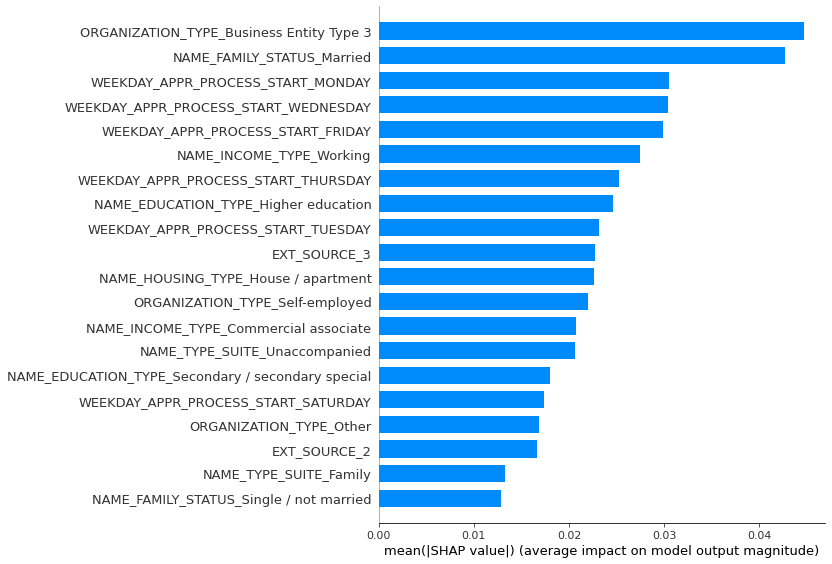

In [32]:
shap_values = shap.KernelExplainer(grid_searchLR.best_estimator_['classifier'].predict, X_train_sample).shap_values(X_train_sample)
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")

In [33]:
shap.initjs()
ramd = 12
shap.force_plot(shap.KernelExplainer(grid_searchLR.best_estimator_['classifier'].predict, X_test_sample).expected_value,
                shap_values[ramd,:],
                X_test_sample.iloc[ramd,:])

## SVM Lineaire

In [34]:
pipeline = imbpipeline(steps = [['smote', SMOTE(n_jobs = 8)],
                                ['scaler', StandardScaler()],
                                ['classifier', LinearSVC(max_iter= 2000)]])
pipeline_ori = imbpipeline(steps = [['smote', SMOTE(n_jobs = 8)],
                                ['scaler', StandardScaler()],
                                ['classifier', LinearSVC(max_iter= 2000)]])


    
param_grid  = {'classifier__C': [0.001, 0.01, 0.05, 0.1, 0.5]}

grid_searchSVM_ori = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=make_scorer(fbeta_score, beta = 0.5, pos_label=0 ,average = "binary"),
                           cv=stratified_kfold,
                           n_jobs=-1,pre_dispatch=40)
               
grid_searchSVM = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=make_scorer(fbeta_score, beta = 0.5, pos_label=0 ,average = "binary"),
                           cv=stratified_kfold,
                           n_jobs=-1,pre_dispatch=40)

grid_searchSVM_ori.fit(X_train_ori, y_train_ori)
best_paramSVM_ori = grid_searchSVM_ori.best_params_
best_estimatorLR_ori = grid_searchSVM_ori.best_estimator_
cv_scoreSVM_ori = grid_searchSVM_ori.best_score_
test_scoreSVM_ori = grid_searchSVM_ori.score(X_test_ori, y_test_ori)
Y_predSVM_ori = grid_searchSVM_ori.predict(X_test_ori)
FB_SVM_ori = fbeta_score(y_test_ori, Y_predSVM_ori, average='binary',pos_label=0, beta=0.5)
accuracySVM_ori = accuracy_score(y_test_ori, Y_predSVM_ori)
roc_aucSVM_ori = roc_auc_score(y_test_ori, Y_predSVM_ori)
precisionSVM_ori = precision_score(y_test_ori, Y_predSVM_ori, pos_label=0)
recallSVM_ori = recall_score(y_test_ori, Y_predSVM_ori, pos_label=0)

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

In [35]:
grid_searchSVM.fit(X_train, y_train)
best_paramSVM = grid_searchSVM.best_params_
best_estimatorLR = grid_searchSVM.best_estimator_
cv_scoreSVM = grid_searchSVM.best_score_
test_scoreSVM = grid_searchSVM.score(X_test, y_test)
Y_predSVM = grid_searchSVM.predict(X_test)
FB_SVM = fbeta_score(y_test, Y_predSVM, average='binary',pos_label=0, beta=0.5)
accuracySVM = accuracy_score(y_test, Y_predSVM)
roc_aucSVM = roc_auc_score(y_test, Y_predSVM)
precisionSVM = precision_score(y_test, Y_predSVM, pos_label=0)
recallSVM = recall_score(y_test, Y_predSVM, pos_label=0)

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

Using 252 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 252/252 [44:13<00:00, 10.53s/it]


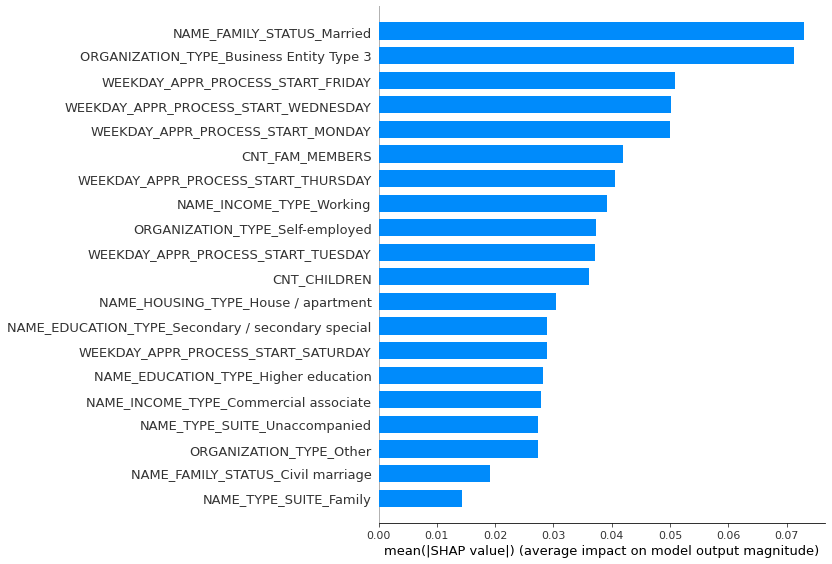

In [36]:
shap_values = shap.KernelExplainer(grid_searchSVM.best_estimator_['classifier'].predict, X_train_sample).shap_values(X_train_sample)
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")

In [37]:
shap.initjs()
ramd = 12
shap.force_plot(shap.KernelExplainer(grid_searchSVM.best_estimator_['classifier'].predict, X_test_sample).expected_value,
                shap_values[ramd,:],
                X_test_sample.iloc[ramd,:])

# RamdomForest


In [38]:
pipeline = imbpipeline(steps = [['smote', SMOTE(n_jobs = 8)],
                                ['scaler', StandardScaler()],
                                ['classifier', RandomForestClassifier(n_jobs=8)]])
pipeline_ori = imbpipeline(steps = [['smote', SMOTE(n_jobs = 8)],
                                ['scaler', StandardScaler()],
                                ['classifier', RandomForestClassifier(n_jobs=8)]])
param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_features': ['auto'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy']
}

grid_searchRF_ori = GridSearchCV(estimator=pipeline_ori,
                           param_grid=param_grid,
                           scoring=make_scorer(fbeta_score,pos_label=0, beta = 0.5, average = 'binary'),
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_searchRF = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=make_scorer(fbeta_score,pos_label=0, beta = 0.5, average = 'binary'),
                           cv=stratified_kfold,
                           n_jobs=-1)


grid_searchRF_ori.fit(X_train_ori, y_train_ori)
cv_scoreRF_ori = grid_searchRF_ori.best_score_
test_scoreRF_ori = grid_searchRF_ori.score(X_test_ori, y_test_ori)
Y_predRF_ori = grid_searchRF_ori.predict(X_test_ori)
FB_RF_ori = fbeta_score(y_test_ori, Y_predRF_ori, average='binary', pos_label=0, beta=0.5)
accuracyRF_ori = accuracy_score(y_test_ori, Y_predRF_ori)
roc_aucRF_ori = roc_auc_score(y_test_ori, Y_predRF_ori)
precisionRF_ori = precision_score(y_test_ori, Y_predRF_ori, pos_label=0)
recallRF_ori = recall_score(y_test_ori, Y_predRF_ori, pos_label=0)


In [39]:
grid_searchRF.fit(X_train, y_train)
cv_scoreRF = grid_searchRF.best_score_
test_scoreRF = grid_searchRF.score(X_test, y_test)
Y_predRF = grid_searchRF.predict(X_test)
FB_RF = fbeta_score(y_test, Y_predRF, average='binary', pos_label=0, beta=0.5)
accuracyRF = accuracy_score(y_test, Y_predRF)
roc_aucRF = roc_auc_score(y_test, Y_predRF)
precisionRF = precision_score(y_test, Y_predRF, pos_label=0)
recallRF = recall_score(y_test, Y_predRF, pos_label=0)

Using 252 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 252/252 [1:06:28<00:00, 15.83s/it]


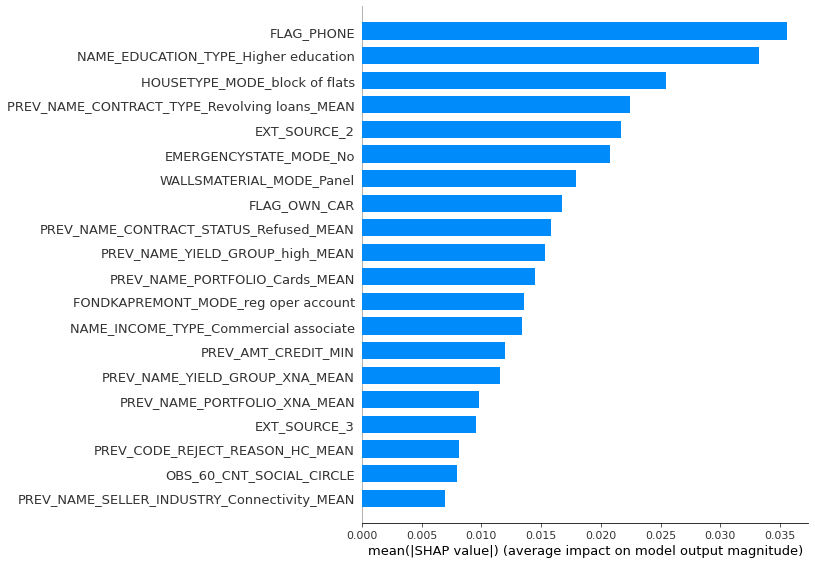

In [40]:
shap_values = shap.KernelExplainer(grid_searchRF.best_estimator_['classifier'].predict, X_train_sample).shap_values(X_train_sample)
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")

In [41]:
shap.initjs()
ramd = 12
shap.force_plot(shap.KernelExplainer(grid_searchRF.best_estimator_['classifier'].predict, X_test_sample).expected_value,
                shap_values[ramd,:],
                X_test_sample.iloc[ramd,:])

# XGBoost

In [42]:
pipeline = imbpipeline(steps = [['smote', SMOTE(n_jobs = 8)],
                                ['scaler', StandardScaler()],
                                ['classifier', XGBClassifier(nthread=8, 
                                                             use_label_encoder=False, 
                                                             objective='binary:logistic', 
                                                             eval_metric ='auc')]])

pipeline_ori = imbpipeline(steps = [['smote', SMOTE(n_jobs = 8)],
                                ['scaler', StandardScaler()],
                                ['classifier', XGBClassifier(nthread=8, 
                                                             use_label_encoder=False, 
                                                             objective='binary:logistic', 
                                                             eval_metric ='auc')]]) 
param_grid = {
                'classifier__learning_rate': [0.08,0.09],
                'classifier__max_depth': [2,4,6,8,9],
                'classifier__n_estimators': [50,100,200,400,500]
        }
grid_searchXG_ori = GridSearchCV(estimator=pipeline_ori,
                           param_grid=param_grid,
                           scoring=make_scorer(fbeta_score, beta = 0.5, pos_label=0 ,average = 'binary'),
                           cv=stratified_kfold,
                           n_jobs=-1)
    
grid_searchXG = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=make_scorer(fbeta_score, beta = 0.5, pos_label=0 ,average = 'binary'),
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_searchXG_ori.fit(X_train_ori, y_train_ori)
cv_scoreXG_ori = grid_searchXG_ori.best_score_
test_scoreXG_ori = grid_searchXG_ori.score(X_test_ori, y_test_ori)
Y_predXG_ori = grid_searchXG_ori.predict(X_test_ori)
FB_XG_ori = fbeta_score(y_test_ori, Y_predXG_ori, average='binary', beta=0.5, pos_label=0)
accuracyXG_ori = accuracy_score(y_test_ori, Y_predXG_ori)
roc_aucXG_ori = roc_auc_score(y_test_ori, Y_predXG_ori)
precisionXG_ori = precision_score(y_test_ori, Y_predXG_ori, pos_label=0)
recallXG_ori = recall_score(y_test_ori, Y_predXG_ori, pos_label=0)

In [43]:
grid_searchXG.fit(X_train, y_train)
cv_scoreXG = grid_searchXG.best_score_
test_scoreXG = grid_searchXG.score(X_test, y_test)
Y_predXG = grid_searchXG.predict(X_test)
FB_XG = fbeta_score(y_test, Y_predXG, average='binary', beta=0.5, pos_label=0)
accuracyXG = accuracy_score(y_test, Y_predXG)
roc_aucXG = roc_auc_score(y_test, Y_predXG)
precisionXG = precision_score(y_test, Y_predXG, pos_label=0)
recallXG = recall_score(y_test, Y_predXG, pos_label=0)

Using 252 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 252/252 [55:56<00:00, 13.32s/it]


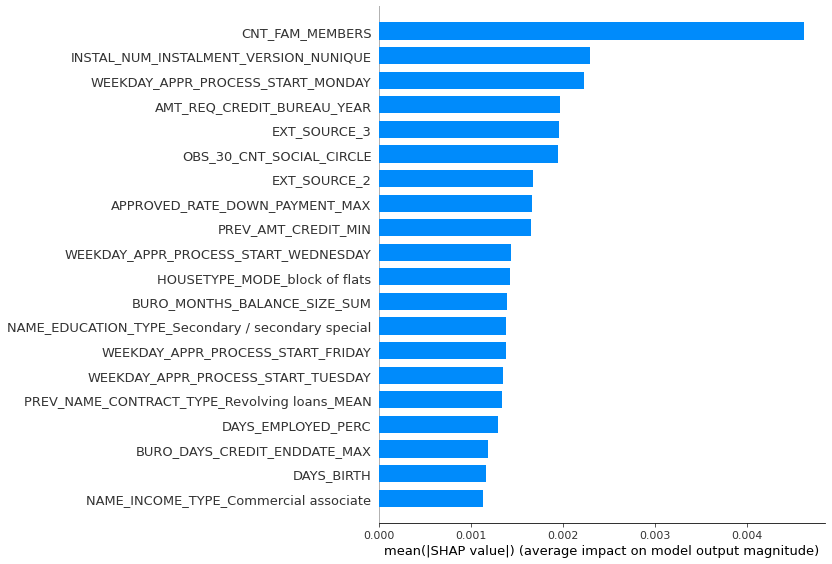

In [44]:
shap_values = shap.KernelExplainer(grid_searchXG.best_estimator_['classifier'].predict, X_train_sample).shap_values(X_train_sample)
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")

In [45]:
shap.initjs()
ramd = 12
shap.force_plot(shap.KernelExplainer(grid_searchXG.best_estimator_['classifier'].predict, X_test_sample).expected_value,
                shap_values[ramd,:],
                X_test_sample.iloc[ramd,:])

In [46]:
results = pd.DataFrame({'Mesure': ["CV score", "Test Score", "FBeta", "Accuracy", "ROC_AUC", "Precision", "Recall"],
                        'LR_ori': [cv_scoreLR_ori, test_scoreLR_ori , FB_LR_ori, accuracyLR_ori, roc_aucLR_ori, precisionLR_ori, recallLR_ori], 
                        'LR': [cv_scoreLR, test_scoreLR, FB_LR, accuracyLR, roc_aucLR, precisionLR, recallLR], 
                        'SVM_ori': [cv_scoreSVM_ori, test_scoreSVM_ori, FB_SVM_ori, accuracySVM_ori, roc_aucSVM_ori, precisionSVM_ori, recallSVM_ori], 
                        'SVM': [cv_scoreSVM, test_scoreSVM, FB_SVM, accuracySVM, roc_aucSVM, precisionSVM, recallSVM], 
                        'RF_ori': [cv_scoreRF_ori, test_scoreRF_ori, FB_RF_ori, accuracyRF_ori, roc_aucRF_ori, precisionRF_ori, recallRF_ori], 
                        'RF': [cv_scoreRF, test_scoreRF, FB_RF_ori, accuracyRF, roc_aucRF, precisionRF, recallRF], 
                        'XG_ori': [cv_scoreXG_ori, test_scoreXG_ori, FB_XG_ori, accuracyXG_ori, roc_aucXG_ori, precisionXG_ori, recallXG_ori], 
                        'XG': [cv_scoreRF, test_scoreRF, FB_RF_ori, accuracyRF, roc_aucRF, precisionRF, recallRF]})

results 

results.to_csv('Results.csv')

In [47]:
results

,Mesure,LR_ori,LR,SVM_ori,SVM,RF_ori,RF,XG_ori,XG
0,CV score,0.912044,0.935573,0.911807,0.934404,0.918424,0.928456,0.935378,0.928456
1,Test Score,0.911404,0.935232,0.911235,0.933961,0.918673,0.925736,0.934632,0.925736
2,FBeta,0.911404,0.935232,0.911235,0.933961,0.918673,0.918673,0.934632,0.918673
3,Accuracy,0.790395,0.917580,0.788993,0.918655,0.830627,0.861959,0.916927,0.861959
4,ROC_AUC,0.585342,0.518055,0.587499,0.501478,0.552675,0.547665,0.513147,0.547665
5,Precision,0.917732,0.921343,0.934669,0.918844,0.927583,0.926409,0.920570,0.926409
6,Recall,0.830275,0.995244,0.828181,0.999752,0.884685,0.923055,0.995457,0.923055
